In [2]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import networkx as nx
import re

In [3]:
file_path = "../mushroom_network_no_edges.pkl"

with open(file_path, 'rb') as f:
    data = pd.read_pickle(f)

In [4]:
# Print number of nodes
print(f"Number of nodes: {data.number_of_nodes()}")

# Print number of edges
print(f"Number of edges: {data.number_of_edges()}")

# Print node attributes
print("Node attributes:")
count = 0
for node, attrs in data.nodes(data=True):
    print(f"Node {node}: {attrs}")
    count += 1
    if count >= 5:
        break

Number of nodes: 1101
Number of edges: 0
Node attributes:
Node 1: {'mushroom': 'Russula maculata', 'id': 1, 'views_all_time': 9897, 'article': 'https://en.wikipedia.org/wiki/Russula_maculata', 'sporePrintColor': ['yellow', 'ochre'], 'howEdible': [], 'stipeCharacter': ['bare'], 'capShape': ['convex', 'depressed'], 'hymeniumType': ['adnexed', 'free'], 'ecologicalType': ['mycorrhizal'], 'whichGills': ['Gills on hymenium'], 'conservation_status': [], 'image': 'https://upload.wikimedia.org/wikipedia/commons/thumb/8/82/1996-02-15_Russula_maculata_Qu%C3%A9l._%26_Roze_117.jpg/250px-1996-02-15_Russula_maculata_Qu%C3%A9l._%26_Roze_117.jpg', 'Genus': 'Russula', 'Family': 'Russulaceae', 'Order': 'Russulales', 'Class': 'Agaricomycetes', 'Division': 'Basidiomycota', 'Species': 'R.\xa0maculata', 'text': 'Russula maculata is a species of mushroom in the genus Russula . [ 1 ] Its cap ranges from 4–10 centimetres ( 1 + 1 ⁄ 2 –4\xa0in) wide, with hues varying from whitish to red. [ 2 ] It is difficult to

In [5]:
# Get all nodes into a dataframe with their attributes
df = pd.DataFrame.from_dict(dict(data.nodes(data=True)), orient='index')

In [6]:
df_text = df['text']

In [7]:
df_text.head(1).values[0]

'Russula maculata is a species of mushroom in the genus Russula . [ 1 ] Its cap ranges from 4–10 centimetres ( 1 + 1 ⁄ 2 –4\xa0in) wide, with hues varying from whitish to red. [ 2 ] It is difficult to distinguish reliably and its edibility is unknown. [ 2 ]\nThis Russulales -related article is a stub . You can help Wikipedia by expanding it .'

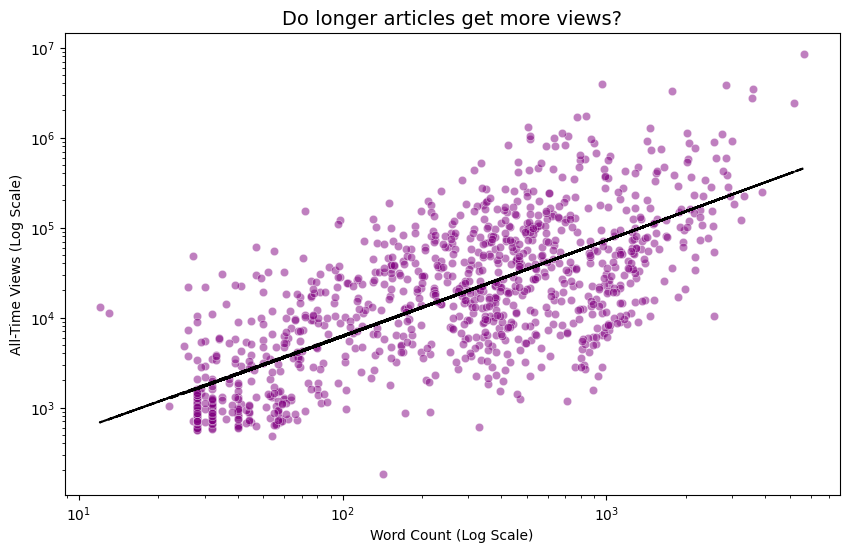

Correlation (Spearman) between Word Count and Views: 0.7028


In [ ]:
# 1. text cleaning functon
def clean_wiki_text(text):
    if not isinstance(text, str):
        return ""
    
    # Remove references like [ 1 ], [ 2 ]
    text = re.sub(r'\[\s*\d+\s*\]', '', text)
    # Remove Wikipedia boilerplate
    text = re.sub(r'This .*? article is a stub\.', '', text)
    text = re.sub(r'You can help Wikipedia by expanding it\.', '', text)
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Apply cleaning
df['clean_text'] = df['text'].apply(clean_wiki_text)

# 2. Calculate Word Count
df['word_count'] = df['clean_text'].apply(lambda x: len(x.split()))

# 3. Analyze: Length vs. Popularity
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='word_count', y='views_all_time', alpha=0.5, color='purple')
plt.yscale('log') # Views are power-law distributed
plt.xscale('log') # Word counts often are too
plt.title('Do longer articles get more views?', fontsize=14)
plt.xlabel('Word Count (Log Scale)')
plt.ylabel('All-Time Views (Log Scale)')

# Add trend line
m, b = np.polyfit(np.log1p(df['word_count']), np.log1p(df['views_all_time']), 1)
plt.plot(df['word_count'], np.exp(b + m * np.log1p(df['word_count'])), color='black', linestyle='--')

plt.show()

print(f"Correlation (Spearman) between Word Count and Views: {df['word_count'].corr(df['views_all_time'], method='spearman'):.4f}")


In [16]:
my_stop_words = [
    # Wikipedia / Academic fluff
    'citation needed', 'citation', 'needed', 'commonly', 'known', 'common', 'name', 
    'described', 'reported', 'according', 'published', 'stub', 'article', 'wikipedia',
    'usually', 'generally', 'typically', 'often', 'although', 'though', 'may', 'can',
    'include', 'including', 'includes', 'contain', 'contains', 'containing',
    
    # Generic Biology
    'mushroom', 'mushrooms', 'species', 'fungus', 'fungi', 'genus', 'variety', 
    'specimen', 'fruit', 'fruiting', 'body', 'bodies', 'group', 'member', 'type',
    'found', 'grow', 'growing', 'grows', 'occur', 'occurs', 'occurring', 
    'distributed', 'distribution', 'range', 'native',
    
    # Generic Anatomy
    'cap', 'stem', 'stipe', 'gill', 'gills', 'spore', 'spores', 'flesh', 'surface', 
    'appearance', 'shape', 'color', 'colour', 'look', 'looks', 'similar',
    
    # Units / Measurements
    'cm', 'mm', 'μm', 'um', 'centimeter', 'millimeter', 'inch', 'diameter', 'wide', 
    'width', 'long', 'length', 'thick', 'thickness', 'size', 'small', 'large', 
    'high', 'low', 'amount', 'level',
    
    # Numbers and time
    'one', 'two', 'three', 'four', 'first', 'second', 'year', 'month', 'day', 'time',
    'spring', 'summer', 'autumn', 'fall', 'winter',
    
    # Abbreviations / Single letters
    'l', 'c', 'p', 'sp', 'spp'
]

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import text

# 1. Setup TF-IDF
# we remove standard English stop words ('the', 'and')
# we also ignore words that appear in >80% of docs (max_df) or <2 docs (min_df)
stop_words = list(text.ENGLISH_STOP_WORDS.union(my_stop_words))


tfidf = TfidfVectorizer(
    stop_words=stop_words, 
    max_df=0.6,  # ignore words appearing in >60% of docs (stricter filter)
    min_df=3     # ignore words appearing in <3 docs
)

# 2. Fit and Transform
tfidf_matrix = tfidf.fit_transform(df['clean_text'])

# 3. View the Top Keywords for the Top 3 most popular mushrooms
# (To verify it worked)
feature_names = np.array(tfidf.get_feature_names_out())

print("Top Keywords for the Most Popular Mushrooms")
top_mushrooms = df.sort_values('views_all_time', ascending=False).head(3)

for idx, row in top_mushrooms.iterrows():
    # Get the row index in the matrix (need to find where it is in the original df)
    # Assuming df index is aligned with matrix rows (0 to N)
    matrix_row_idx = df.index.get_loc(idx)
    
    # Get the vector
    row_vector = tfidf_matrix[matrix_row_idx]
    
    # Sort data to find top scoring words
    # (data is the score, indices is the word ID)
    sorted_indices = np.argsort(row_vector.data)[::-1][:50] # Top 10 words
    top_words = feature_names[row_vector.indices[sorted_indices]]
    
    print(f"\n{row['mushroom']} ({row['views_all_time']} views):")
    print(", ".join(top_words))

Top Keywords for the Most Popular Mushrooms

Amanita muscaria (8460394 views):
muscaria, muscimol, amanita, fly, ibotenic, use, acid, agaric, siberia, effects, urine, peoples, theory, used, food, wasson, poisoning, shamans, psychoactive, muscarine, caesarea, santa, alternative, children, novel, people, story, agarics, speaking, description, century, work, receptors, flies, books, white, consumption, veil, book, red, ingestion, remnants, water, australia, legal, toxins, treatment, reports, warts, 19th

Agaricus bisporus (3916960 views):
bisporus, manure, bispora, brown, psalliota, agaricus, commercial, cultivation, worldwide, white, farm, paris, micrograms, spawn, sinuatum, immature, varieties, cultivated, 1925, xanthodermus, spored, marketed, entoloma, renamed, history, fields, names, pure, grassy, discovered, world, wild, grown, 100, source, scientific, good, red, food, countries, state, botanist, fresh, narrow, propagation, vitamins, loam, flushes, unreliable, ferdinand

Psilocybe cu

In [18]:
from sklearn.metrics.pairwise import linear_kernel

# Calculate Cosine Similarity Matrix
# Result is a N x N matrix where cell [i, j] is the similarity between mushroom i and j
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

# e.g.: Check similarity between the first two mushrooms
print(f"Semantic Similarity between Mushroom 0 and 1: {cosine_sim[0, 1]:.4f}")

Semantic Similarity between Mushroom 0 and 1: 0.2809


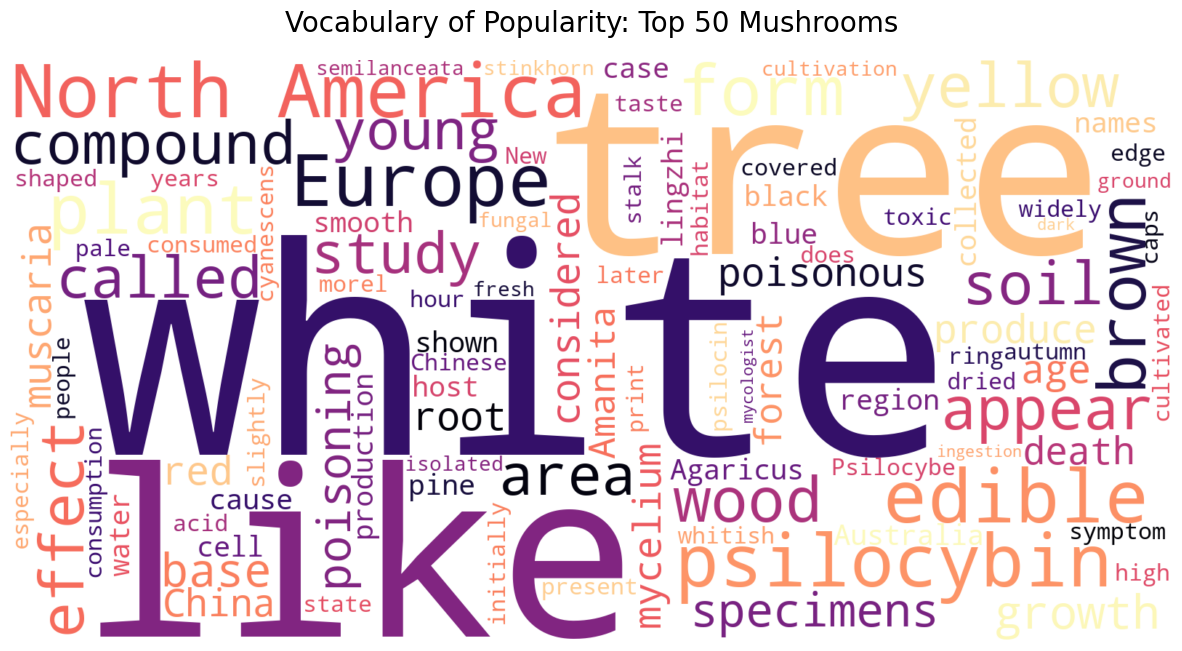

In [19]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import pandas as pd

# 1. Define the Stop Words (reuse the list we created)
# This is crucial, otherwise the biggest word will be "Mushroom"
from sklearn.feature_extraction import text

my_stop_words = [
    'citation', 'needed', 'commonly', 'known', 'common', 'name', 
    'described', 'reported', 'according', 'published', 'stub', 'article', 'wikipedia',
    'usually', 'generally', 'typically', 'often', 'although', 'though', 'may', 'can',
    'include', 'including', 'includes', 'contain', 'contains', 'containing',
    'mushroom', 'mushrooms', 'species', 'fungus', 'fungi', 'genus', 'variety', 
    'specimen', 'fruit', 'fruiting', 'body', 'bodies', 'group', 'member', 'type',
    'found', 'grow', 'growing', 'grows', 'occur', 'occurs', 'occurring', 
    'distributed', 'distribution', 'range', 'native',
    'cap', 'stem', 'stipe', 'gill', 'gills', 'spore', 'spores', 'flesh', 'surface', 
    'appearance', 'shape', 'color', 'colour', 'look', 'looks', 'similar',
    'cm', 'mm', 'μm', 'um', 'centimeter', 'millimeter', 'inch', 'diameter', 'wide', 
    'width', 'long', 'length', 'thick', 'thickness', 'size', 'small', 'large', 
    'one', 'two', 'three', 'four', 'first', 'second', 'year', 'month', 'day', 'time',
    'l', 'c', 'p', 'sp', 'spp', 'use', 'used'
]
stop_words = list(text.ENGLISH_STOP_WORDS.union(my_stop_words))

# 2. Filter for the Top 50 Popular Mushrooms
top_50_df = df.sort_values('views_all_time', ascending=False).head(50)

# 3. Combine all their text into one giant string
# We use the 'clean_text' column we made earlier
text_blob = " ".join(top_50_df['clean_text'].astype(str))

# 4. Generate the Word Cloud
wordcloud = WordCloud(
    width=1600, 
    height=800, 
    background_color='white', 
    stopwords=stop_words,
    colormap='magma', # 'magma' or 'cividis' are good earth-tone palettes
    max_words=100,
    collocations=True # Allows bigrams like "North America" or "Amanita muscaria"
).generate(text_blob)

# 5. Plot
plt.figure(figsize=(15, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off') # Remove x/y axis numbers
plt.title('Vocabulary of Popularity: Top 50 Mushrooms', fontsize=20, pad=20)
plt.show()

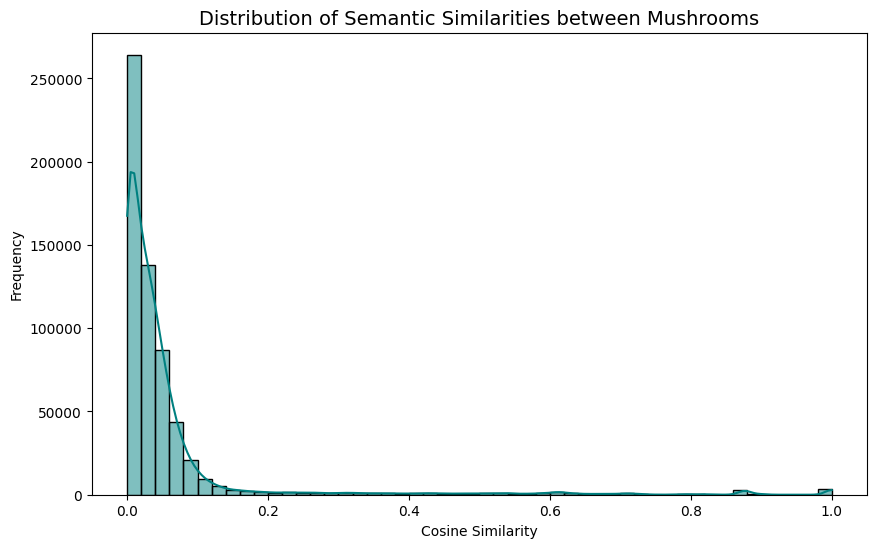

In [20]:
# Plot distribution of similarities
sim_values = cosine_sim[np.triu_indices_from(cosine_sim, k=1)]
plt.figure(figsize=(10, 6))
sns.histplot(sim_values, bins=50, color='teal', kde=True)
plt.title('Distribution of Semantic Similarities between Mushrooms', fontsize=14)
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.show()

In [21]:
# Print distribution of similarity values in intervals of 10 as text
bins = np.linspace(0, 1, 11)
hist, bin_edges = np.histogram(sim_values, bins=bins)
for i in range(len(hist)):
    print(f"Similarity {bin_edges[i]:.1f} - {bin_edges[i+1]:.1f}: {hist[i]} pairs")

Similarity 0.0 - 0.1: 553346 pairs
Similarity 0.1 - 0.2: 21732 pairs
Similarity 0.2 - 0.3: 5947 pairs
Similarity 0.3 - 0.4: 4495 pairs
Similarity 0.4 - 0.5: 3805 pairs
Similarity 0.5 - 0.6: 3881 pairs
Similarity 0.6 - 0.7: 4025 pairs
Similarity 0.7 - 0.8: 1685 pairs
Similarity 0.8 - 0.9: 3277 pairs
Similarity 0.9 - 1.0: 801 pairs
